In [29]:
import pandas as pd
from helpermodules import memory_handling as mh
import numpy as np
from datetime import timedelta, datetime
import time

In [30]:
# downloading the pickle file 
file = "fedspeeches_preprocessed.pkl"
helper = mh.PickleHelper.pickle_load(file)
df_speech = helper.obj

In [32]:
df = pd.read_csv("/Users/baudotedua/Dropbox/Mac/Documents/GitHub/cb-impact-nlps/US SPX 500 (Mini) 1 Minute (1).csv")
columns_to_keep = ['<Date>', ' <Time>', ' <Open>', ' <Close>', ' <TotalVolume>']
df = df[columns_to_keep]
df.columns = ['date', 'time', 'open', 'close', 'volume']
print(df.columns)
# combining date and time in one column (format datetime)
df['datetime'] = pd.to_datetime(df['date'] + ' ' + df['time'], format='%d/%m/%Y %H:%M:%S')
print(df['datetime'].dtype)
df = df.drop(columns=['time'])
df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y')
df = df[['datetime'] + [col for col in df.columns if col != 'datetime']]

Index(['date', 'time', 'open', 'close', 'volume'], dtype='object')
datetime64[ns]


In [33]:
# choosing only the assigned speakers for the analysis
speaker_list_riccardo = [ 'Vice Chair Janet L. Yellen', 'Governor Sarah Bloom Raskin', 'Governor Jeremy C. Stein', 'Governor Jerome H. Powell', 'Chairman  Ben S. Bernanke', 'Governor Lael Brainard', 'Chair Janet L. Yellen', 'Vice Chairman Stanley Fischer', 'Vice Chairman for Supervision Randal K. Quarles', 'Chairman Jerome H. Powell', 'Vice Chairman Richard H. Clarida', 'Chair Jerome H. Powell', 'Vice Chair Richard H. Clarida', 'Vice Chair for Supervision Randal K. Quarles']
speaker_list_fabio = ['Governor Michelle W. Bowman', 'Vice Chair for Supervision and Chair of the Financial Stability Board Randal K. Quarles', 'Vice Chairman for Supervision and Chair of the Financial Stability Board Randal K. Quarles', 'Governor Christopher J. Waller', 'Governor Randal K. Quarles', 'Vice Chair for Supervision Michael S. Barr', 'Governor Lisa D. Cook', 'Vice Chair Lael Brainard', 'Governor Philip N. Jefferson', 'Chair Pro Tempore Jerome H. Powell', 'Vice Chair Philip N. Jefferson', 'Governor Adriana D. Kugler']
df_speech = df_speech[df_speech['speaker'].isin(speaker_list_fabio)]

In [34]:
def data_retrieve_minute(df, ticker):
    """
    Retrieve minute-level time series data for a specified ticker using the Twelve Data API.

    Parameters:
    df : pandas.DataFrame
        A dataframe containing at least two columns:
        - 'date': Dates for which data needs to be retrieved.
        - 'timestamp': Timestamps corresponding to the data entries.
    ticker : str
        The symbol of the financial instrument to retrieve data for.

    Returns:
    dffinal : pandas.DataFrame
        A concatenated DataFrame containing minute-level data for the specified ticker
        across all the unique dates in the provided dataframe `df`. The DataFrame will have:
        - 'date' as the index
        - A 'timestamp' column representing the minute-level time series.
    """
    
    timelist = df.date.unique().tolist()
    count = 0
    dffinal = pd.DataFrame()

    for date in timelist:
        print(f"Processing date: {date}")
        start = df[df['date'] == date].timestamp.min() - pd.Timedelta(minutes=15)
        end = df[df['date'] == date].timestamp.max() + pd.Timedelta(minutes=15)

        if count % 8 == 0 and count > 0:
            time.sleep(60)

        try:
            etf = td.time_series(
                symbol=ticker,
                interval="1min",
                start_date=start,
                end_date=end,
                outputsize=5000    
            ).as_pandas()
            
            # If the API call returns data, concatenate it to the final DataFrame
            if not etf.empty:
                # Add a 'date' column to the ETF DataFrame to use as an index later
                etf['date'] = date
                dffinal = pd.concat([dffinal, etf], ignore_index=False)
            else:
                print(f"No data available for {date}")

        except Exception as e:
            print(f"Error retrieving data for {date}: {e}")

        count += 1
    
    # Set the 'date' as the index and move 'timestamp' into a separate column
    dffinal.reset_index(inplace=True)
    dffinal.rename(columns={'index': 'timestamp'}, inplace=True)
    dffinal.set_index('date', inplace=True)
    
    return dffinal


In [35]:
def volatility_calculator(df , column):
    """
    Calculate daily volatility for the 'open' column in the dataframe.

    Parameters:
    df : pandas.DataFrame
        A dataframe containing at least 'date' and 'open' columns.
    column : string 
        The name of the column we want to calculate the standard deviation on

    Returns:
    pandas.Series
        A series with dates as the index and the standard deviation
        of 'open' values (volatility) as the values.
    """

    volatility_series = df.groupby('date')[column].std()
    return volatility_series

In [36]:
def clean_df(df):
    """
    Clean the dataframe by sorting and filtering based on date and weekdays.

    Parameters:
    df : pandas.DataFrame
        A dataframe containing at least 'date' and 'timestamp' columns.

    Returns:
    pandas.DataFrame
        A dataframe sorted by 'date' and 'timestamp', filtered to include only
        rows with dates >= '2020-12-01' and weekdays (Monday to Friday).
    """
        
    df_ordered = df.sort_values(by=['date', 'timestamp'], ascending = [True, True])
    df_final = df_ordered[df_ordered.date >= "2024-01-01"]
    df_final = df_final[df_final['date'].dt.weekday<5]
    return df_final

In [37]:
def get_best_values(volatility, df, number):
    """
    Filter the dataframe for the speeches with the highest volatility,
    calculating the 'length' as the number of rows for the same speech (identified by title),
    and ensuring each title appears only once. The volatility values are included in the result.

    Parameters:
    volatility : pandas.Series
        A series with dates as the index and volatility as the values.
    df : pandas.DataFrame
        The dataframe to filter, containing 'title' and 'date' columns.
    number : int
        The number of top volatility dates to select.

    Returns:
    pandas.DataFrame
        A filtered dataframe containing the top `number` speeches with the highest volatility,
        including a 'length' column, with each title appearing only once, and volatility in the last column.
    """
    # Sort the volatility in descending order
    volatility = volatility.sort_values(ascending=False)

    # Get the top `number` dates with the highest volatility
    top_dates = volatility.head(number).index.tolist()

    # Filter the dataframe for rows where 'date' is in the top_dates
    filtered_df = df[df['date'].isin(top_dates)]

    # Group by 'title' and calculate the length
    grouped_df = filtered_df.groupby('title').agg(
        date=('date', 'first'),  # Take the first date for each title
        length=('title', 'count')  # Count the number of rows for each title
    ).reset_index()

    # Add the volatility value by joining the `volatility` series with `grouped_df`
    grouped_df['volatility'] = grouped_df['date'].map(volatility)

    # Keep only the top `number` rows sorted by the corresponding volatility
    #grouped_df = grouped_df.loc[grouped_df['date'].isin(top_dates)].head(number)

    return grouped_df


In [38]:
def filter_price_df(df_price, df_speech):
    # Ensure the `timestamp` column in df_speech is in datetime format and remove timezone info
    df_speech['timestamp'] = pd.to_datetime(df_speech['timestamp']).dt.tz_localize(None)
    
    # Ensure the `datetime` column in df_price is in datetime format and remove timezone info
    df_price['datetime'] = pd.to_datetime(df_price['datetime']).dt.tz_localize(None)
    
    # Extract unique dates from df_speech
    datelist = df_speech['timestamp'].dt.date.unique().tolist()
    
    df_return = pd.DataFrame()
    
    for date in datelist:
        # Filter rows for the specific date in df_speech
        date_speech = df_speech.loc[df_speech['timestamp'].dt.date == date]
        min_timestamp = date_speech['timestamp'].min()
        max_timestamp = date_speech['timestamp'].max()
        
        # Filter rows for the specific date in df_price within the min and max timestamp range
        date_price = df_price.loc[
            (df_price['datetime'].dt.date == date) &
            (df_price['datetime'] >= min_timestamp) &
            (df_price['datetime'] <= max_timestamp)
        ]
        
        # Append filtered rows to the result
        df_return = pd.concat([df_return, date_price], ignore_index=True)

    return df_return


In [39]:
df_speech=clean_df(df_speech)

In [40]:
df_price = filter_price_df(df,df_speech)

In [41]:
volatility = volatility_calculator(df_price , 'close')

In [42]:
finaldf = get_best_values(volatility , df_speech , 10)

In [43]:
finaldf = finaldf.sort_values(by='volatility', ascending=False)
finaldf

,title,date,length,volatility
0,"Artificial Intelligence, Big Data, and the Pat...",2024-10-01,17,8.555683
8,Supporting Entrepreneurship & Small Businesses,2024-02-07,12,7.635400
13,The Outlook for the Economy and Monetary Policy,2024-02-07,21,7.635400
2,Challenges to the Community Banking Model,2024-10-11,17,7.582832
6,Recent Views on Monetary Policy and the Econom...,2024-09-26,18,6.768646
9,Supporting Market Resilience and Financial Sta...,2024-09-26,19,6.768646
14,What Will Artificial Intelligence Mean for Ame...,2024-09-26,24,6.768646
7,Remarks on the Economic Outlook and Financial ...,2024-08-20,22,6.432751
11,The Future of Stress Testing and the Stress Ca...,2024-09-10,30,6.265992
12,The Next Steps on Capital,2024-09-10,24,6.265992


In [44]:
def calculate_ret(df):
    """
    Adds a column to the dataframe that contains the percentage change
    of successive values of a price column, with the option to group by 'date'.
    
    Args:
    df (pd.DataFrame): The input dataframe with a price column.
    
    Returns:
    pd.DataFrame: The original dataframe with an additional column for percentage change.
    """
    # Group by 'date' and calculate the percentage change within each group
    df['percentage_change'] = df.groupby('date')['close'].pct_change()



In [45]:
def calculate_cum_ret(df):
    """
    Adds a column to the dataframe that contains the cumulative returns
    of a price column, with the option to group by 'date'.
    
    Args:
    df (pd.DataFrame): The input dataframe with a price column.
    
    Returns:
    pd.DataFrame: The original dataframe with an additional column for cumulative returns.
    """
    # Group by 'date' and calculate cumulative returns within each group
    df['cumulative_returns'] = (1 + df.groupby('date')['close'].pct_change()).cumprod()

In [46]:
calculate_ret(df_price)
calculate_cum_ret(df_price)

Now I try to calculate the top variance speeches by using the percentage change instead of the closing prices

In [47]:
volatility_pctchange = volatility_calculator(df_price, 'percentage_change')
dffinal_pct = get_best_values(volatility_pctchange, df_speech, 10)
dffinal_pct = dffinal_pct.sort_values(by='volatility', ascending = False)
dffinal_pct

,title,date,length,volatility
7,Statement by Governor Michelle W. Bowman,2024-09-20,3,0.001005
0,Brief Remarks on the Economy and Monetary Policy,2024-05-03,8,0.000964
2,"Hope, Promise, and Mentors",2024-04-01,7,0.000636
5,Risks and Uncertainty in Monetary Policy: Curr...,2024-04-05,33,0.000576
4,Recent Views on Monetary Policy and the Econom...,2024-09-24,18,0.000531
1,Economic Uncertainty and the Evolution of Mone...,2024-04-16,20,0.000498
3,Lessons from the American Economic Association...,2024-06-14,10,0.000479
8,"Tailoring, Fidelity to the Rule of Law, and Un...",2024-03-05,18,0.000475
6,Some Thoughts on r*: Why Did It Fall and Will...,2024-05-24,26,0.000473
9,The Future of Stress Testing and the Stress Ca...,2024-09-10,30,0.000465


We have different results !

In [ ]:

def get_best_values_cumret(df_price, df, number):
    """
    Filter the dataframe for the top dates with the highest cumulative return values for the corresponding timestamps.

    Parameters:
    df_price : pandas.DataFrame
        A dataframe containing price values, including 'datetime' and 'cumulative_returns'.
    df : pandas.DataFrame
        The dataframe to filter, containing 'title' and 'timestamp' columns.
    number : int
        The number of top cumulative return dates to select.

    Returns:
    pandas.DataFrame
        A filtered dataframe containing rows with the top `number` cumulative return dates.
    """
    # Create a date column in the original DataFrame
    df['date'] = pd.to_datetime(df['timestamp']).dt.date

    # Group by both title and date to handle speeches with the same name on different dates
    grouped = df.groupby(['title', 'date'])

    # Get the earliest and latest timestamps for each title-date group
    min_timestamps = grouped['timestamp'].min()
    max_timestamps = grouped['timestamp'].max()

    # Combine into a DataFrame
    timestamps = pd.DataFrame({
        'min_timestamp': min_timestamps,
        'max_timestamp': max_timestamps
    }).reset_index()

    # Retrieve corresponding cumulative return values from df_price
    cumret_values = []
    for _, row in timestamps.iterrows():
        # Filter rows in df_price for the max_timestamp
        matching_row = df_price[df_price['datetime'] == row['max_timestamp']]
        if not matching_row.empty:
            cumret_values.append(matching_row['cumulative_returns'].iloc[0])  # Access the value directly
        else:
            cumret_values.append(float('-inf'))  # Handle missing timestamps

    # Combine titles, timestamps, and cumulative return values into a DataFrame
    cumret_df = pd.DataFrame({
        'title': timestamps['title'],
        'date': timestamps['date'],
        'min_timestamp': timestamps['min_timestamp'],
        'max_timestamp': timestamps['max_timestamp'],
        'cumulative_returns': cumret_values
    })

    # Calculate the length of the speech (number of entries for the same title-date group)
    cumret_df['speech_length'] = grouped.size().values

    # Sort by cumulative_returns in descending order and select the top rows
    cumret_df = cumret_df.sort_values(by='cumulative_returns', ascending=False).head(number)

    return cumret_df



In [67]:
dffinal_cumret = get_best_values_cumret(df_price, df_speech, 10)

In [68]:
dffinal_cumret

,title,date,min_timestamp,max_timestamp,cumulative_returns,speech_length
11,"Brief Remarks on the Economy, Monetary Policy,...",2024-06-27,2024-06-27 10:00:00,2024-06-27 10:21:00,1.014504,22
37,Moving Toward Better Balance and Implications ...,2024-06-25,2024-06-25 10:06:00,2024-06-25 10:25:00,1.014320,20
42,Opening Remarks,2024-06-25,2024-06-25 10:00:00,2024-06-25 10:05:00,1.014228,6
66,The Consequences of Bank Capital Reform,2024-06-26,2024-06-26 10:00:00,2024-06-26 10:18:00,1.014134,19
49,Promoting an Inclusive Financial System,2024-07-09,2024-07-09 10:00:00,2024-07-09 10:10:00,1.013832,11
16,Common Inflation and Monetary Policy Challenge...,2024-07-10,2024-07-10 10:00:00,2024-07-10 10:20:00,1.013687,21
43,Opening Remarks,2024-07-10,2024-07-10 10:21:00,2024-07-10 10:25:00,1.013506,5
24,"Financial Inclusion: Past, Present, and Hopes ...",2024-07-09,2024-07-09 10:11:00,2024-07-09 10:29:00,1.013433,19
48,Perspectives on U.S. Monetary Policy and Bank ...,2024-06-25,2024-06-25 10:26:00,2024-06-25 10:56:00,1.013393,31
85,Welcoming Remarks,2024-06-24,2024-06-24 10:00:00,2024-06-24 10:05:00,1.012855,6


In [69]:
def get_best_values_volume(df_price, df, number):
    """
    Filter the dataframe for the top dates with the highest average volume values for the corresponding timestamps.

    Parameters:
    df_price : pandas.DataFrame
        A dataframe containing price values, including 'datetime' and 'volume'.
    df : pandas.DataFrame
        The dataframe to filter, containing 'title' and 'timestamp' columns.
    number : int
        The number of top average volume dates to select.

    Returns:
    pandas.DataFrame
        A filtered dataframe containing rows with the top `number` average volume dates.
    """
    # Create a date column in the original DataFrame
    df['date'] = pd.to_datetime(df['timestamp']).dt.date

    # Group by both title and date
    grouped = df.groupby(['title', 'date'])

    # Get the earliest and latest timestamps for each title-date group
    min_timestamps = grouped['timestamp'].min()
    max_timestamps = grouped['timestamp'].max()

    # Combine into a DataFrame
    timestamps = pd.DataFrame({
        'min_timestamp': min_timestamps,
        'max_timestamp': max_timestamps
    }).reset_index()

    # Retrieve corresponding average volume values from df_price
    volume_values = []
    for _, row in timestamps.iterrows():
        # Filter rows in df_price within the range of min_timestamp to max_timestamp
        matching_rows = df_price[
            (df_price['datetime'] >= row['min_timestamp']) & 
            (df_price['datetime'] <= row['max_timestamp'])
        ]
        if not matching_rows.empty:
            volume_values.append(matching_rows['volume'].mean().round(2))  # Calculate average volume
        else:
            volume_values.append(float('-inf'))  # Handle missing timestamps

    # Combine titles, timestamps, and average volume values into a DataFrame
    volume_df = pd.DataFrame({
        'title': timestamps['title'],
        'date': timestamps['date'],
        'min_timestamp': timestamps['min_timestamp'],
        'max_timestamp': timestamps['max_timestamp'],
        'avg_volume': volume_values
    })

    # Calculate the length of the speech (number of entries for the same title-date group)
    volume_df['speech_length'] = grouped.size().values

    # Sort by avg_volume in descending order and select the top rows
    volume_df = volume_df.sort_values(by='avg_volume', ascending=False).head(number)

    return volume_df


In [70]:
dffinal_volume = get_best_values_volume(df_price, df_speech, 10)
dffinal_volume

,title,date,min_timestamp,max_timestamp,avg_volume,speech_length
80,The Time Has Come,2024-09-06,2024-09-06 10:00:00,2024-09-06 10:18:00,12216.84,19
6,"Artificial Intelligence, Big Data, and the Pat...",2024-10-01,2024-10-01 10:00:00,2024-10-01 10:16:00,11005.88,17
26,Getting Closer,2024-07-17,2024-07-17 10:00:00,2024-07-17 10:21:00,10448.18,22
28,"Hope, Promise, and Mentors",2024-04-01,2024-04-01 10:00:00,2024-04-01 10:06:00,10142.86,7
72,The Future of Stress Testing and the Stress Ca...,2024-09-10,2024-09-10 10:00:00,2024-09-10 10:29:00,10084.00,30
41,Opening Remarks,2024-04-18,2024-04-18 10:00:00,2024-04-18 10:08:00,10058.33,9
60,Statement by Governor Michelle W. Bowman,2024-09-20,2024-09-20 10:00:00,2024-09-20 10:02:00,9986.67,3
65,The Challenges Facing Economic Measurement and...,2024-07-16,2024-07-16 10:00:00,2024-07-16 10:28:00,9882.76,29
51,Recent Views on Monetary Policy and the Econom...,2024-09-26,2024-09-26 10:46:00,2024-09-26 11:03:00,9468.89,18
76,The Next Steps on Capital,2024-09-10,2024-09-10 10:30:00,2024-09-10 10:53:00,9453.33,24


------

Trying to plot a mock-up sentiment score behaviour vs the percentage change of the stock

In [71]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.polynomial.polynomial import Polynomial

In [87]:
import numpy as np
import matplotlib.pyplot as plt

def plot_sentiment_vs_cumret(sentiment_score, prices, degree=2):
    """
    Plots sentiment scores and cumulative returns as line plots, with a polynomial approximation.

    Parameters:
    sentiment_score : array-like
        Array of sentiment score values.
    prices : array-like
        Array of cumulative return values.
    degree : int, optional
        Degree of the polynomial approximation (default is 2).

    Returns:
    None
    """
    # Ensure inputs are numpy arrays for compatibility
    sentiment_score = np.array(sentiment_score)
    prices = np.array(prices)

    # Create a time index (assuming both arrays are for the same time period)
    time_index = np.arange(len(sentiment_score))

    # Plot both sentiment_score and prices as lines
    plt.figure(figsize=(10, 6))
    plt.plot(time_index, sentiment_score, color='blue', label='Sentiment Score', linewidth=2)
    plt.plot(time_index, prices, color='red', label='Cumulative Return', linewidth=2)

    # Polynomial fit for sentiment_score
    coeffs_sentiment = np.polyfit(time_index, sentiment_score, degree)
    poly_sentiment = np.poly1d(coeffs_sentiment)
    plt.plot(time_index, poly_sentiment(time_index), color='blue', linestyle='--', label=f'Sentiment Polynomial Approx (degree {degree})')

    # Polynomial fit for prices
    coeffs_prices = np.polyfit(time_index, prices, degree)
    poly_prices = np.poly1d(coeffs_prices)
    plt.plot(time_index, poly_prices(time_index), color='red', linestyle='--', label=f'Cumulative Return Polynomial Approx (degree {degree})')

    # Add labels, legend, and title
    plt.xlabel('Time Period', fontsize=12)
    plt.ylabel('Values', fontsize=12)
    plt.title('Sentiment Score vs Cumulative Return', fontsize=14)
    plt.legend()
    plt.grid(alpha=0.3)

    # Show plot
    plt.show()


In [ ]:
# Get the rows for the first date
first_date_prices = df_price[df_price['date'] == df_price['date'].unique()[0]]

# Create the sentiment scores for this subset
sentiment_score = np.random.normal(loc=0, scale=0.5, size=len(first_date_prices))

# Clip values to the range [-1, 1]
sentiment_score = np.clip(sentiment_score, -1, 1)

# Extract the 'cumulative_returns' values for the first date
prices = np.array(first_date_prices['percentage_change'])*10e02  #why do I have to multiply it by 100 ? -> study 
#possible better ways of scaling datas 


In [119]:
prices

array([        nan, -0.16963528, -0.57261622,  0.14854111,  0.46677417,
        0.53017772,  0.02119587, -0.08478169, -0.08478888, -0.02119902,
       -0.31799199,  0.19085588, -0.19081946, -0.25447451, -0.27575089,
        0.12730475,  0.40308038, -0.29688693,  0.40303763, -0.42407922,
        0.55153688, -0.31801895,  0.21208008,  0.08481405, -0.21201713,
        0.2332683 ,  0.10600632,  0.08479607,  0.        ])

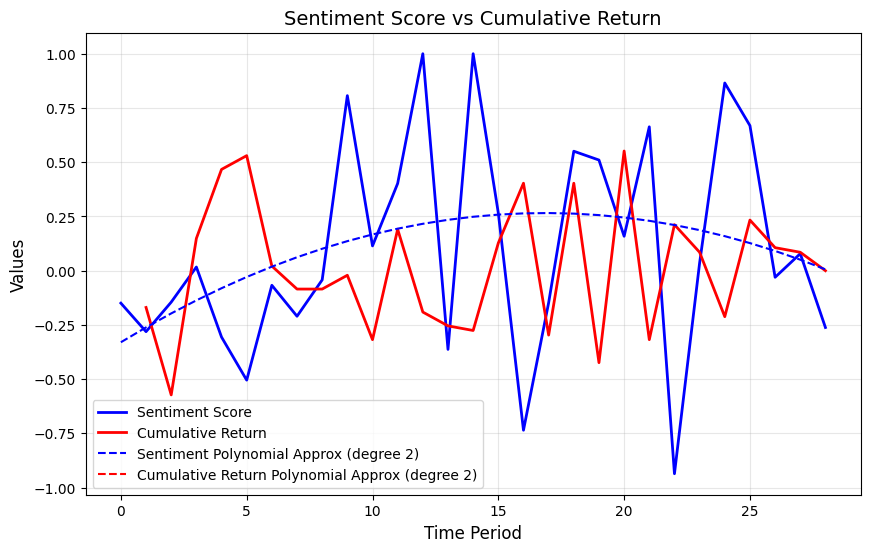

In [120]:
plot_sentiment_vs_cumret(sentiment_score, prices, 2)

------

Cute displaying of wordcloud, nice for final report and better visualization

In [121]:
from wordcloud import WordCloud

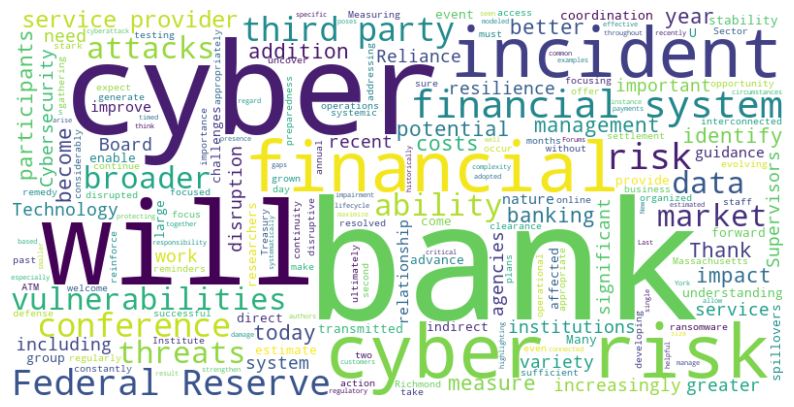

In [129]:
# i have to access a speech 
speech = "Thank you for the opportunity to welcome you to day two of the second annual Conference on Measuring Cyber Risk in the Financial Services Sector.1 I'd like to thank the staff who organized this gathering from the Massachusetts Institute of Technology, the Federal Reserve Bank of Richmond, and the Federal Reserve Board.Cyber threats are constantly evolving, and we can expect them to become increasingly disruptive as technology advances and our financial system becomes more interconnected. In the past few months, ransomware attacks have disrupted the ability of some financial institutions to offer a variety of banking and market services, including Treasury clearance and settlement and access to online banking and ATM operations. These incidents were resolved without significant disruption to the broader market, but they are stark reminders of the potential for cyber incidents to generate broader, even systemic risks, and the importance of addressing these risks.Cybersecurity preparedness has become increasingly important for banks. Banks must take action to uncover vulnerabilities in their systems and remedy those vulnerabilities before attacks occur. But focusing on cyber defense is not sufficient. It is important that banks also focus on resilience to successful cyber-attacks, including by developing and regularly testing business continuity plans.The Federal Reserve and other banking agencies work to make sure that banks and service providers are appropriately focused on cybersecurity and operational resilience. Supervisors will continue to reinforce the need for appropriate risk management.Reliance by banks on third-party service providers has grown considerably in recent years, and with that reliance comes the potential for greater cyber risk.2 It is ultimately the responsibility of banks to manage their third-party risk, and we have historically seen gaps in this regard. Last year, together with the other bank regulatory agencies, the Federal Reserve adopted guidance on effective management of third-party risk, based on the size and complexity of the bank and nature of the third-party relationship. The guidance provides some specific examples throughout the lifecycle of a third-party relationship, which should be helpful for banks as they strengthen their management of these risks.Forums like today's conference are critical to improve how we think about and measure the presence of cyber risk in financial markets. The ability to better measure cyber risk will allow banks and supervisors to improve their understanding of the direct and indirect costs of a cyber disruption. An incident poses direct costs on an affected bank and its customers, as well as indirect costs to other market participants who are connected to the affected bank. For instance, researchers at the New York Federal Reserve Bank recently modeled how a cyber incident could be transmitted through the U.S. financial system under a variety of circumstances.3 The authors estimate how the impairment of a single large bank, a group of smaller banks, or a common service provider could be transmitted through the payments system and result in significant spillovers to other banks. Spillovers to the broader financial system are estimated to be especially large when attacks are timed to maximize damage, further highlighting challenges that arise with protecting against cyber risk. In addition, the researchers estimate that the potential impact of a cyberattack is systematically greater during stressed financial conditions. This indicates that we need a deeper understanding of how cyber risk interacts with traditional challenges to financial stability.4 Many of the participants in today's conference are working on research that will advance our knowledge of cyber risk and financial stability, and I am looking forward to continuing to follow work in this area.Despite progress in recent years, techniques to quantify cyber risk are still at a nascent stage, in part because of a lack of good data. Better data on cyber threats and vulnerabilities will enable us to identify and assess threats to banks and the financial system. In addition, improved data on interconnectedness between financial institutions and service providers will help identify and measure the impact of an incident on the broader financial system. The ability to quickly identify patterns, connections, and vulnerabilities will enable quick response, and may mean the difference between a controlled event and one that has a serious impact. We are supporting efforts to further study this subject through public-private coordination groups. In addition, cyber incident reporting will provide better data on the frequency, severity, and locality of cyber incidents that will enhance our collective ability to respond to these events.I am heartened to see that many of the attendees and speakers at this conference come not just from the United States, but also from around the globe. Today's globalized financial system and the global nature of cyber threats demand international coordination from both participants and regulators. In closing, I look forward to hearing more about what you all accomplish during the remainder of the conference, in furtherance of a more resilient financial system.Thank you.1. The views expressed here are my own and are not necessarily those of my colleagues on the Federal Reserve Board."
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(speech)

# Display the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Turn off axis
plt.show()


Next steps:

-> make sure the timestamps are correct

-> plot the sentiment score vs the percentage change

-> calculate the linear correlation 

-> conclude 

-> set up the paper